# Pedestrian Crash - Trying to predict XYZ at the time of impact
## Read the dataset

Try to predict the exact timestep of collision

## Importing the libraries

In [14]:
# edo eimai, predict XYZ coords in collision. write them in the thesis. Watch out the last layer. It is linear.
# 2) Predict exact collision time.
# 3) Predict relative move rnn
# 4) use kans
# i am trying to perform normalization here. not working....

from pathlib import Path
import sys
sys.path.insert(0, "C:\\Users\geork\projects\AIThesis\src\src")
import matplotlib.pyplot as plt

from dataset_reader import DatasetReaderCSV

## Read the dataset

In [15]:
path = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_3\\dataset.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Id", "Position", "Path", "GifPath", "Head_Collision_X", "Head_Collision_Y", "Head_Collision_Z", "CarProfile"], errors="ignore")

In [16]:
print(df.dtypes)

Velocity                    int64
Translation                 int64
Rotation                    int64
Head_Collision_XYZ_index    int64
Bumber_Height               int64
Front_Hood_Height           int64
Bumber_Hood_Angle           int64
Hood_Length                 int64
Back_Hood_Height            int64
dtype: object


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Assuming df is your DataFrame
# Define features (X) and targets (y)
X = df.drop(columns=['Head_Collision_XYZ_index'])
y = df[['Head_Collision_XYZ_index']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # the collision timestep
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
filepath = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_3\\5_3_3\\mlp\\model_5_3_3.keras")
model_checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, 
                    callbacks=[
                        #early_stopping, 
                        reduce_lr,
                        model_checkpoint
                        ])

c:\Users\geork\projects\AIThesis\src\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 13624.8232 - val_loss: 13946.7344 - learning_rate: 0.0010
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13450.8975 - val_loss: 13888.3340 - learning_rate: 0.0010
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13223.9492 - val_loss: 13824.9023 - learning_rate: 0.0010
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13120.9795 - val_loss: 13740.9961 - learning_rate: 0.0010
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13234.6318 - val_loss: 13607.2314 - learning_rate: 0.0010
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12990.3105 - val_loss: 13477.7988 - learning_rate: 0.0010
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12567.6084 - val_loss: 13332.6240 - learning_rate: 0.0010
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 12498.9385 - val_loss: 13121.2627 - learning_rate: 0.0010
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.8509 
Test Loss: 106.68095397949219
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
    Predicted
0  117.526581
1   91.056442
2   97.958786
3  107.084274
4   85.231766


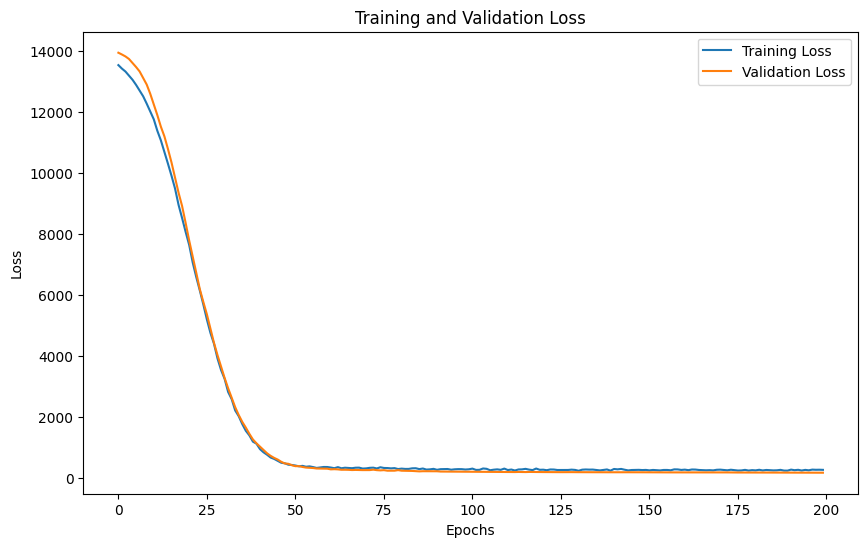

In [19]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)

# If you want to see the predictions
predictions_df = pd.DataFrame(y_pred, columns=['Predicted'])
print(predictions_df.head())

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
      Head_Collision_XYZ_index
319                        117
956                        116
1182                       136
86                         106
990                         83
...                        ...
1043                        82
993                         93
224                        152
724                        137
965                         80

[238 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
Ended
   True_Head_Collision_XYZ_index
0                            117
1                            116
2                            136
3                            106
4                             83
   Predicted_Head_Collision_XYZ_index
0                          117.526581
1                           91.056442
2                           97.958786
3                          107.084274
4                           85.231766


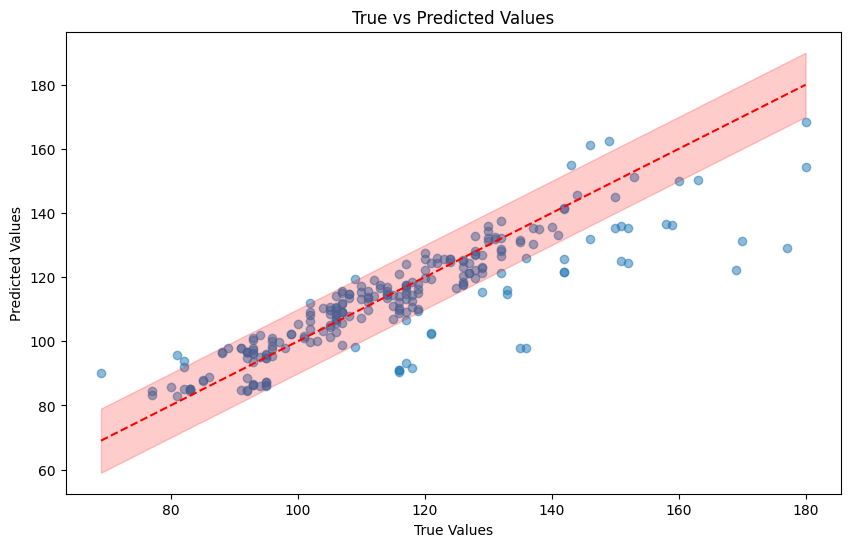

In [20]:
import pandas as pd

# Make predictions
y_pred = model.predict(X_test)
# Assuming y_test is the true values and y_pred are the predictions

print(y_test)
print(type(y_test))
print("Ended")
y_test = y_test.reset_index(drop=True).rename(columns={'Head_Collision_XYZ_index': 'True_Head_Collision_XYZ_index'})
y_test_df = y_test
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted_Head_Collision_XYZ_index'])

# Merge true and predicted values into a single DataFrame
comparison_df = pd.concat([y_test_df, y_pred_df], axis=1)

error_range = 10  # 25 mm on each side of the perfect prediction line

# Function to plot with shaded error region
def plot_with_error_region(ax, true_vals, pred_vals, title):
    ax.scatter(true_vals, pred_vals, alpha=0.5)
    ax.set_xlabel('True Values (mm)')
    ax.set_ylabel('Predicted Values (mm)')
    ax.set_title(title)

    # Plot line of perfect prediction
    ax.plot([true_vals.min(), true_vals.max()], 
            [true_vals.min(), true_vals.max()], 
            color='red', linestyle='--')  
    
    # Plot shaded error region
    ax.fill_between([true_vals.min(), true_vals.max()], 
                    [true_vals.min() - error_range, true_vals.max() - error_range],
                    [true_vals.min() + error_range, true_vals.max() + error_range],
                    color='red', alpha=0.2)  # Light red shaded region

# Plot for the first dimension (X)
# plot_with_error_region( 
#                        comparison_df['True_Head_Collision_X'], 
#                        comparison_df['Predicted_Head_Collision_X'], 
#                        'True vs Predicted Values (Dimension X)')
print(y_test_df.head())
print(y_pred_df.head())
# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['True_Head_Collision_XYZ_index'], comparison_df['Predicted_Head_Collision_XYZ_index'], alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([comparison_df['True_Head_Collision_XYZ_index'].min(), comparison_df['True_Head_Collision_XYZ_index'].max()], 
         [comparison_df['True_Head_Collision_XYZ_index'].min(), comparison_df['True_Head_Collision_XYZ_index'].max()], 
         color='red', linestyle='--')  # Line of perfect prediction

             # Plot shaded error region
plt.fill_between([comparison_df['True_Head_Collision_XYZ_index'].min(), comparison_df['True_Head_Collision_XYZ_index'].max()], 
                [comparison_df['True_Head_Collision_XYZ_index'].min() - error_range, comparison_df['True_Head_Collision_XYZ_index'].max() - error_range],
                [comparison_df['True_Head_Collision_XYZ_index'].min() + error_range, comparison_df['True_Head_Collision_XYZ_index'].max() + error_range],
                color='red', alpha=0.2)  # Light red shaded region
plt.show()